# Historical Predictions
This notebook contains the code for the Historical Predictions.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install world-bank-data

In [ ]:
cd /content/drive/MyDrive/src

/content/drive/MyDrive/src


In [ ]:
from lib import estimator_util as eu
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

In [ ]:
sns.set_theme()

In [ ]:
continent: str = 'africa'
models: list = range(3)
model_names: list = ['ResNet18', 'ResNet50', 'ResNet152']

In [ ]:
complete_dfs = []
all_cols_list = []

for model in models:
    complete_df, all_cols = eu.get_data(f"../data/continents/{continent}/lsms/processed/_all_real.csv", f"../data/continents/{continent}/model_{model}/cnn_features/cnn.csv", f"../data/continents/{continent}/")
    complete_dfs.append(complete_df)
    all_cols_list.append(all_cols_list)

## All Countries
Historical future and past predictions for all countries.

In [ ]:
def all_year_run(complete_df):
    countries = complete_df.groupby(["country"]).groups.keys()
    base_year = []
    year_ = []
    r2 = []
    country_ = []
    for country in countries:
        years = complete_df.loc[complete_df["country"] == country].groupby(["year"]).groups.keys()
        for year in years:
            for x_year in years:
                X_base, y_base = eu.get_features(complete_df, [country], [year], all_cols)
                if year == x_year:
                    r, _, m = eu.run_ridge(X_base, y_base)
                    country_.append(country)
                    base_year.append(year)
                    year_.append(x_year)
                    r2.append(r)
                    continue
                infl = eu.get_inflation_perf(country, year, x_year)
                X, y = eu.get_features(complete_df, [country], [x_year], all_cols, infl=infl)
                n = len(X_base)
                X = StandardScaler().fit_transform(X)
                r, y_hest, m = eu.run_ridge_out(X_base, y_base, X, y, alpha=10000)
                country_.append(country)
                base_year.append(year)
                year_.append(x_year)
                r2.append(r)
    return pd.DataFrame.from_dict({"Country": country_,"Train Year": base_year, "Eval Year": year_, "r2": r2})
        

In [ ]:
for complete_df in complete_dfs:
    print(all_year_run(complete_df))

   Country  Train Year  Eval Year        r2
0      ETH        2013       2013  0.153499
1      ETH        2013       2015  0.110210
2      ETH        2013       2018  0.104314
3      ETH        2015       2013  0.141533
4      ETH        2015       2015  0.182340
5      ETH        2015       2018  0.248308
6      ETH        2018       2013  0.078069
7      ETH        2018       2015  0.123662
8      ETH        2018       2018  0.307679
9      MLI        2015       2015  0.155285
10     MLI        2015       2019  0.176707
11     MLI        2019       2015  0.031899
12     MLI        2019       2019  0.475905
13      MW        2016       2016  0.527226
14      MW        2016       2019  0.460967
15      MW        2019       2016  0.485659
16      MW        2019       2019  0.507070
17     NER        2019       2019  0.538820
18      NG        2012       2012  0.086459
19      NG        2012       2015  0.049517
20      NG        2012       2018  0.092263
21      NG        2015       201

## Leave-one-out

In [ ]:
for complete_df in complete_dfs:
    countries = ["ETH", "NG", "MLI", "UGA"]
    for country in countries:
        print(f"======{country}=====")
        years = list(complete_df.loc[complete_df["country"] == country].groupby(["year"]).groups.keys())
        loo = LeaveOneOut()
        X_ = None
        y_ = None
        for year, x_year in loo.split(years):
            for y in year:
                infl = eu.get_inflation_perf(country, 2010, years[y])
                X_base, y_base = eu.get_features(complete_df, [country], [years[y]], all_cols, infl)
                
                if X_ is None:
                    X_ = X_base
                else:
                    X_ = np.vstack((X_, X_base))
                
                if y_ is None:
                    y_ = y_base
                else:
                    y_ = np.append(y_, y_base)

            infl = eu.get_inflation_perf(country, 2010, years[x_year[0]])
            X, y = eu.get_features(complete_df, [country], [years[x_year[0]]], all_cols, infl=infl)
            X_ = StandardScaler().fit_transform(X_)
            X = StandardScaler().fit_transform(X)
            r, y_hest, m = eu.run_ridge_out(X_, y_, X, y, alpha=1000)
            print(f"Predicting: {years[x_year[0]]}")
            print(r)

## Pooled Dataset
Predictions for whole dataset. Consumption is scaled to base year 2010.

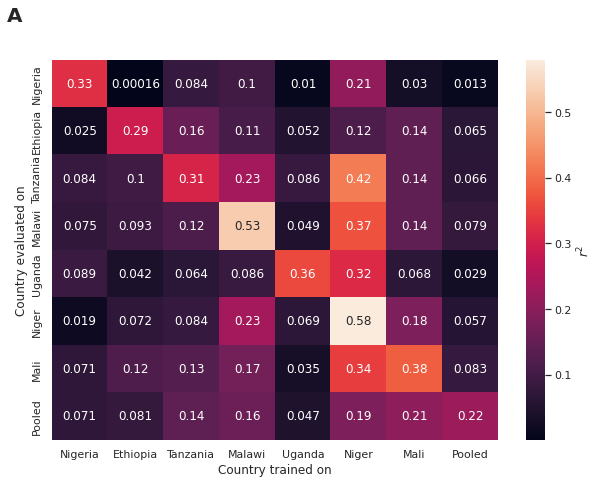

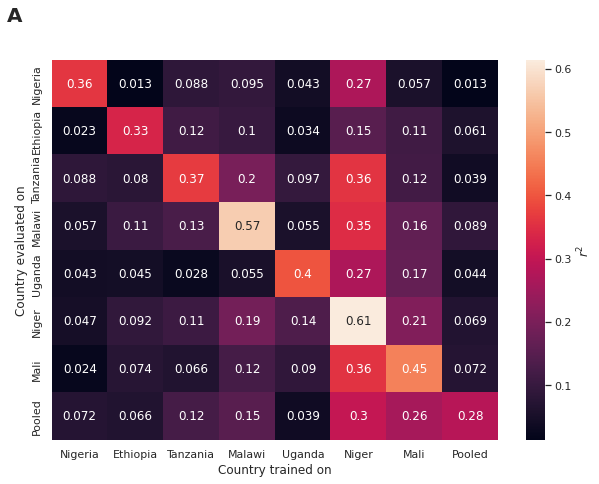

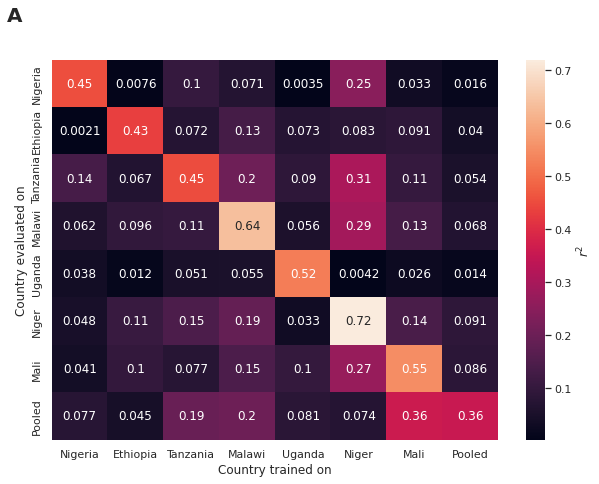

In [ ]:
for k, complete_df in enumerate(complete_dfs):
    countries = [["NG"], ["ETH"] ,["TZA"], ["MW"], ["UGA"], ["NER"], ["MLI"], ["NG", "ETH", "TZA", "MW", "UGA", "NER", "MLI"]]
    arr = np.zeros((8,8))
    for i, country in enumerate(countries):
        X, y = eu.get_features_allyears(complete_df, country, all_cols)
        for j, out_country in enumerate(countries):
            X_out, y_out = eu.get_features_allyears(complete_df,out_country, all_cols)
            r, _, _= eu.run_ridge_out(X, y, X_out, y_out)
            arr[i,j] = r
    countries = ["Nigeria", "Ethiopia" ,"Tanzania", "Malawi", "Uganda", "Niger", "Mali", "Pooled"]
    df_cm = pd.DataFrame(arr, index = countries, columns = countries)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cbar_kws={'label': r'$r^2$'})
    plt.xlabel("Country trained on")
    plt.ylabel("Country evaluated on")
    ax = plt.gca()
    plt.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig(f"../data/continents/{continent}/{model_names[k]}/figs/cross_country_pooled_timetravel.pdf", dpi=600, bbox_inches="tight")

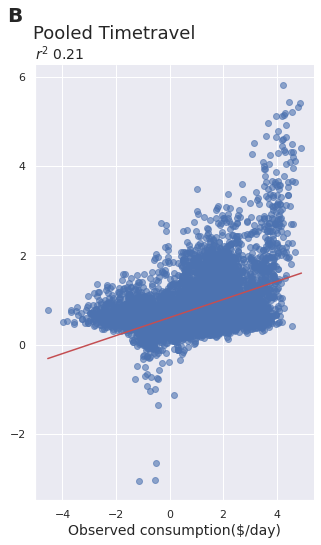

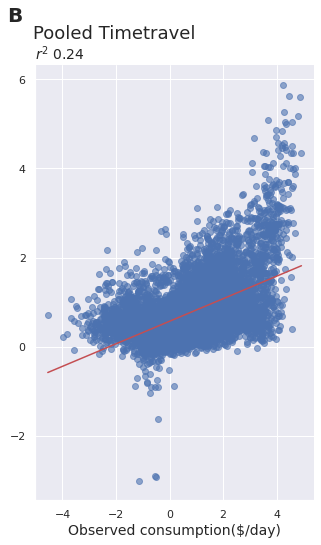

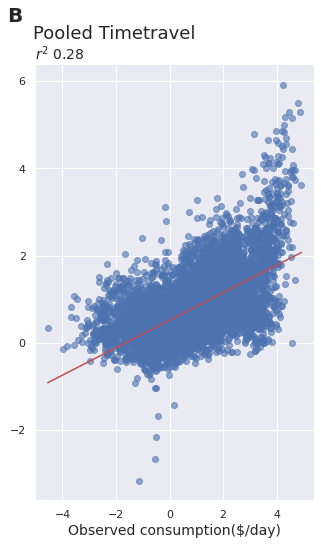

In [ ]:
for complete_df in complete_dfs:
    country = ["NG", "ETH", "TZA", "MW", "UGA", "NER", "MLI"]
    X, y = eu.get_features_allyears(complete_df, country, all_cols)
    r, _, m = eu.run_ridge(X, y)
    y_hest = m.predict(X)
    eu.plot_predictions(y, y_hest, r, "Pooled", "Timetravel", 1)